In [1]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import scipy.interpolate
from pandas import DataFrame
from IPython.display import clear_output
from dtaidistance import dtw, dtw_visualisation as dtwvis, clustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from matplotlib.pyplot import *
from scipy.spatial.distance import squareform
from skbio.stats.distance import DissimilarityMatrix
from sklearn.preprocessing import normalize
from sklearn import manifold
from matplotlib.lines import Line2D
import seaborn as sns
from os import listdir

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/antonvoskresenskii/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['draw_if_interactive']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Well data import

In [2]:
path = 'RAW DATA/Well Data_LAS/'
list_of_wells = listdir(path)
files_to_remove = ['WellA.dev', 'WellB.dev', 'WellC.dev', 'WellD.dev', 'WellE.dev', 'WellF.dev', 
                   'Coordinates.xlsx', '.ipynb_checkpoints', 'Polygons_Watt', 'Watt_Voronoi.ipynb', 
                   'Coordinates copy.xlsx', '.DS_Store', 'Coordinates_hist.xlsx', '~$Workbook1.xlsx',
                  'Workbook1.xlsx', 'core data.xlsx', 'log data.xlsx']
list_of_wells = [i for i in list_of_wells if i not in files_to_remove]
list_of_wells.sort()
print(list_of_wells)

['WellA.las', 'WellB.las', 'WellC.las', 'WellD.las', 'WellE.las', 'WellF.las']


In [3]:
df = DataFrame()
columns = list(range(0, 4))
for i in range(len(list_of_wells)):
    data = pd.read_csv(path + list_of_wells[i], header = None, usecols = columns, sep = '\s+')
    data = data.iloc[30:, :]
    data = data.reset_index(drop = True)
    header = ['Depth', 'Permeability', 'NTG', 'Porosity']
    data.columns = header
    data['Well'] = list_of_wells[i][4:-4]
    print(data.shape)
    df = df.append(data, ignore_index = True)
df = df.replace('-999.250000', np.NaN)
df.Depth = df.Depth.astype(float)
df.Permeability = df.Permeability.astype(float)
df.NTG = df.NTG.astype(float)
df.Porosity = df.Porosity.astype(float)
print(df.Well.unique())
print(df.shape)
df.head()

(3601, 5)
(3401, 5)
(584, 5)
(767, 5)
(1650, 5)
(1949, 5)
['A' 'B' 'C' 'D' 'E' 'F']
(11952, 5)


,Depth,Permeability,NTG,Porosity,Well
0,1580.00,5.000000e-10,1.0,NaN,A
1,1580.05,5.000000e-10,1.0,NaN,A
2,1580.10,5.000000e-10,1.0,NaN,A
3,1580.15,5.000000e-10,1.0,NaN,A
4,1580.20,5.000000e-10,1.0,NaN,A


у каротажей разный шаг дискретизации поэтому нужно привести их к примерно к одному значению количества точек замера в скважине

In [4]:
log = 'Porosity' # или 'Permeability'
temp_df = pd.DataFrame()
for i in df.Well.unique():
    temp = df.loc[df.Well == i]
    temp = temp.filter(items = [log])
    temp = temp.dropna()
    temp = temp.reset_index(drop  = True)
    temp.columns = [i]
    temp = pd.Series(temp[i])
    list_temp = []
    if (i == 'A' or i == 'B'):
        for j in range(len(temp)):
            if j % 6 == 0:
                list_temp.append(temp[j])
    if (i == 'E' or i == 'F'):
        for j in range(len(temp)):
            if j % 3 == 0:
                list_temp.append(temp[j])
    if (i == 'C' or i == 'D'):  
        list_temp = temp
    list_temp = pd.DataFrame(list_temp)
    list_temp.columns = [i]
    temp_df = pd.concat([temp_df, list_temp], axis = 1, sort = False)
    print(i, len(temp), len(list_temp))
print(temp_df.shape)   
temp_df = temp_df.fillna(0)
# первое число было до убирания 'лишних' значений, второе стало после
temp_df.head()

A 2941 491
B 2801 467
C 550 550
D 752 752
E 1623 541
F 1779 593
(752, 6)


,A,B,C,D,E,F
0,0.0893,0.1012,0.095200,0.0655,0.0774,0.0774
1,0.0833,0.0952,0.083305,0.0774,0.0714,0.0714
2,0.0833,0.0893,0.083300,0.0893,0.0833,0.0774
3,0.0893,0.0952,0.089300,0.0893,0.0833,0.0714
4,0.0893,0.1071,0.089300,0.0893,0.0833,0.0774


вот код чтобы убедиться в том, что форма все та же

(752, 6)


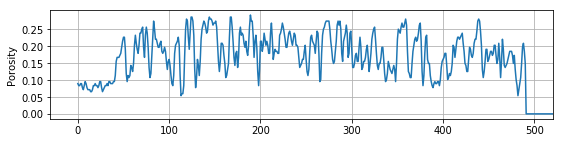

(3601, 5)


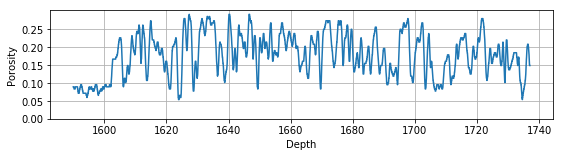

In [5]:
ymin = 0
ymax = 0.3
ystep = 0.05
plt.figure(figsize = (9, 2))
plt.plot(temp_df.loc[:, 'A'])
plt.ylabel('Porosity')
plt.grid(True)
plt.xlim(-30, 520)
plt.yticks(np.arange(ymin, ymax, ystep))
print(temp_df.shape)
plt.show()

plt.figure(figsize = (9, 2))
temp = df.loc[df.Well == 'A']
plt.plot(temp.filter(items = ['Depth']), temp.filter(items = ['Porosity']))
plt.ylabel('Porosity')
plt.xlabel('Depth')
plt.yticks(np.arange(ymin, ymax, ystep))
plt.grid(True)
print(temp.shape)
plt.show()

/Users/antonvoskresenskii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/antonvoskresenskii/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
/Users/antonvoskresenskii/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


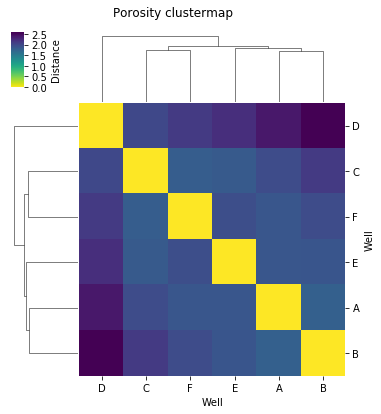

In [6]:
series = temp_df.T.as_matrix()
series /= np.atleast_2d(series.max(axis = 1)).T
distances = pdist(series, dtw.distance_fast)
a = pd.DataFrame(data = squareform(distances), index = temp_df.columns, columns = temp_df.columns)
cg = sns.clustermap(a, cmap = 'viridis_r', figsize=(6, 6))
cg.fig.suptitle('Porosity clustermap')
plt.ylabel('Distance')
ax = cg.ax_heatmap
ax.set_xlabel('Well')
ax.set_ylabel('Well')
cg.fig.subplots_adjust(top = 0.92)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0);

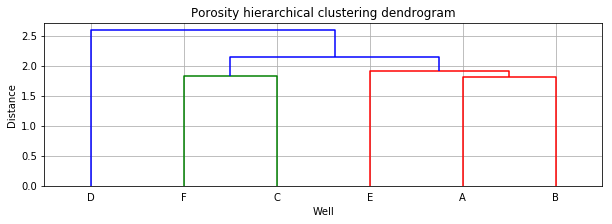

In [7]:
plt.figure(figsize=(10, 3))
links = linkage(distances, method = 'complete', metric = 'euclidean', optimal_ordering = True)
plt.title('Porosity hierarchical clustering dendrogram')
plt.xlabel('Well', fontsize = 10)
plt.ylabel('Distance')
dn = dendrogram(links, color_threshold = 2, leaf_font_size = 10, 
                labels = temp_df.columns, leaf_rotation = 0)
plt.grid()

0
[5 2]
['F', 'C']
---
1
[0 1 4]
['A', 'B', 'E']
---
2
[3]
['D']
---


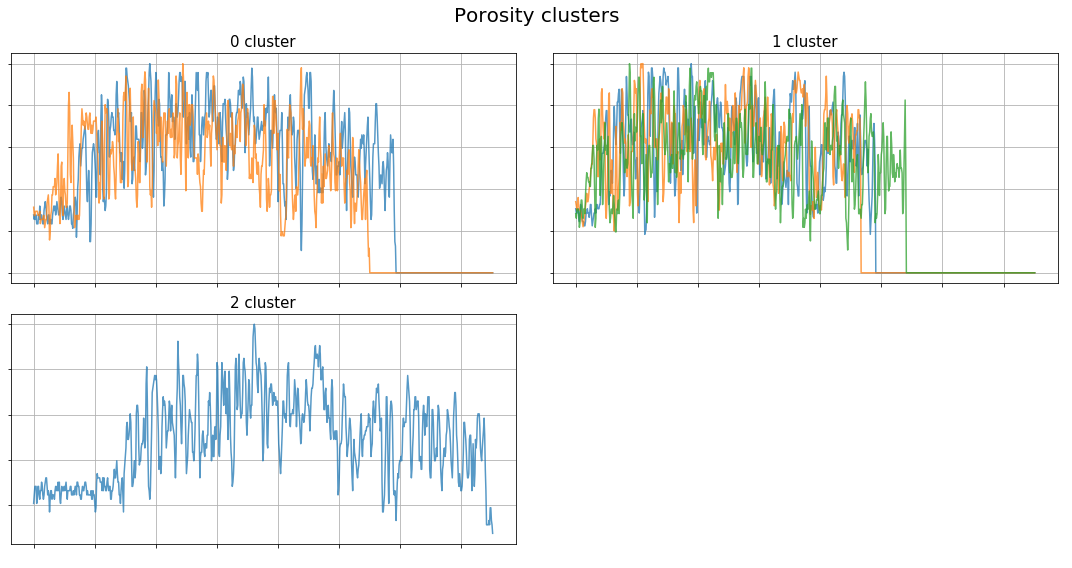

In [8]:
well_names_list = temp_df.columns
well_names_list = np.asarray(well_names_list)
final_well_list = []
final_cluster_list = []
def visualize_clusters(series, links, num_clusters, 
                       num_series_to_draw = 3,
                       draw_align = 'original',
                       make_gray = False):
    
    results = fcluster(links, num_clusters, criterion = 'maxclust')
    s = pd.Series(results)
    clusters = s.unique()
    ncols = 2
    nrows = np.ceil(len(clusters) / float(ncols)).astype(int)
    def get_series_to_plot(series, align = 'original'):
        if align == 'original':
            return series
        elif align == 'dtw':
            output_series = [series[0]]
            for i in range(1, len(series)):
                path = np.array(dtw.warping_path(series[0], series[i]))
                output_series.append(series[i, path[:, 1]])
            return output_series
        elif align == 'shift':
            output_series = [series[0]]
            for i in range(1, len(series)):
                path = np.array(dtw.warping_path(series[0], series[i]))
                path_diff = path[:, 0] - path[:, 1]
                counts, lefts = np.histogram(path_diff, bins = np.max(path_diff) - np.min(path_diff))
                left = -lefts[np.argmax(counts)].astype(int) 
                if left > 0:
                    output_series.append(series[i][left:])
                else:
                    output_series.append(np.hstack((np.zeros(-left), series[i])))
            return output_series
        else:
            raise ValueError('')
    count = 0
    f, axs = subplots(ncols = ncols, nrows = nrows, figsize = (15, 4 * nrows))
    for row in range(nrows):
        for col in range(ncols):
            ax = axs[row, col] if nrows > 1 else axs[col]
            cluster_idx = row * ncols + col
            if cluster_idx >= len(clusters):
                ax.axis('off')
                break
            print(count)
            cluster_indices = s[s == cluster_idx + 1].index
            num_series_to_select = min(num_series_to_draw, len(cluster_indices))
            cluster_indices = np.random.choice(cluster_indices, num_series_to_select, replace = False)
            print(cluster_indices)
            well_list = []
            for i in well_names_list[cluster_indices]:
                well_list.append(i)
            print(well_list)
            cluster_list = []
            for i in well_names_list[cluster_indices]:
                cluster_list.append(count)
            print('---')
            series_to_plot = get_series_to_plot(series[cluster_indices, :], align = draw_align)
            plt.suptitle('Porosity clusters', fontsize = 20)   
            for y in series_to_plot:
                if make_gray:
                    ax.plot(y, color = 'gray', alpha = 0.75)
                else:
                    ax.plot(y, alpha = 0.75)
                ax.set_title(str(count) + ' cluster', fontsize = 15)
                ax.get_xaxis().set_ticklabels([])
                ax.get_yaxis().set_ticklabels([])
            final_well_list.append(well_list)
            final_cluster_list.append(cluster_list)
            count += 1
            ax.grid(True)          
    plt.tight_layout()
    plt.subplots_adjust(top = 0.90)
num_clusters = 3
num_series_to_draw = 100
draw_align = 'original'
make_gray = False
visualize_clusters(series, links, num_clusters, num_series_to_draw, draw_align, make_gray)

In [9]:
flattened_wells = [y for x in final_well_list for y in x]
flattened_clusters = [y for x in final_cluster_list for y in x]
wells_and_clusters = pd.DataFrame({'Well': flattened_wells, 'Cluster': flattened_clusters})
wells_and_clusters.to_pickle('Clusters/poro.pkl')
wells_and_clusters.head(20)

,Well,Cluster
0,F,0
1,C,0
2,A,1
3,B,1
4,E,1
5,D,2


In [10]:
df_box = wells_and_clusters.merge(df, on = 'Well', how = 'left')
df_box = df_box.dropna(how = 'any')
df_box.head()

,Well,Cluster,Depth,Permeability,NTG,Porosity
0,F,0,1555.09998,0.212087,1.0,0.077400
1,F,0,1555.19998,0.185721,1.0,0.077400
2,F,0,1555.29998,0.173562,1.0,0.071407
3,F,0,1555.39998,0.162055,1.0,0.071400
4,F,0,1555.49998,0.241387,1.0,0.077400


In [11]:
def plot(x, y, xmin, xmax, xstep, ymin, ymax, ystep, xlabel, ylabel,fontsize, yaxis, **kwargs):
    plt.plot(x, y, **kwargs)
    plt.grid(True)
    plt.xlabel(xlabel, fontsize = fontsize)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xticks(np.arange(xmin, xmax, xstep))
    plt.yticks(np.arange(ymin, ymax, ystep))
    if yaxis == True:  
        plt.ylabel('Depth, m', fontsize = fontsize)
    if yaxis == False:    
        plt.gca().axes.get_yaxis().set_ticklabels([])

In [12]:
# если кластеризуем пористость то нужно выполнить этот код
ymin = 1550
ymax = 1790
ystep = 25
xmin = 0
xmax = .35
xstep = 0.1
xlabel = 'Porosity, ' + r'$m^3/m^3$'
ylabel = 'Depth, m'
fontsize = 10

In [ ]:
# если кластеризуем проницаемость то нужно выполнить этот код
ymin = 1550
ymax = 1790
ystep = 25
xmin = 0
xmax = 1000
xstep = 250
xlabel = 'Permeability, mD' 
ylabel = 'Depth, m'
fontsize = 10

In [13]:
header = temp_df.columns.values
print(header)
wells = list(wells_and_clusters.Well.values)
clusters = list(wells_and_clusters.Cluster.values)
print(wells)
print(clusters)
clusters = np.array(clusters)
well_names = []
for j in np.unique(clusters):
    sublist = []
    for i in range(len(clusters)):
        if clusters[i] == j:
            temp = wells[i]
            sublist.append(temp)
    well_names.append(sublist)    
print(well_names)

['A' 'B' 'C' 'D' 'E' 'F']
['F', 'C', 'A', 'B', 'E', 'D']
[0, 0, 1, 1, 1, 2]
[['F', 'C'], ['A', 'B', 'E'], ['D']]


In [14]:
customPalette = ['green',  '#39C8C6', 'red', '#630C3A', 'Orange', '#3498DB', 'Tomato', 'Violet', "#9B59B6", 
                 "#3498DB", "Coral", "#E74C3C", "Brown", "Goldenrod", '#630C3A', '#39C8C6', 
                 'Orange', '#3498DB', 'Tomato', 'Violet', "#9B59B6", "#3498DB", "Coral", 
                 "#E74C3C", "Brown", "Goldenrod"]

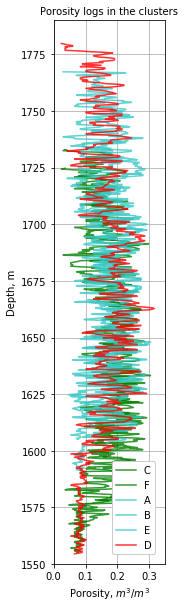

In [15]:
# если проницаемость кластеризуем то в 9 строке поменять на 'Permeability'
plt.figure(figsize = (2, 10))
plt.title('Porosity logs in the clusters', fontsize = fontsize)
yaxis = True
for j in range(len(np.unique(clusters))):
    for i in header:
        if i in well_names[j]:
            temp = df.loc[df.Well == i]
            temp = temp.filter(items = ['Porosity', 'Depth']).dropna()
            temp = temp.reset_index(drop  = True)
            plot(x = temp.iloc[:, 0], y = temp.iloc[:, 1], xmin = xmin, xmax = xmax, 
                  xstep = xstep, ymin = ymin, ymax = ymax, ystep = ystep, xlabel = xlabel, 
                  ylabel = ylabel, color = customPalette[j], alpha = 0.8, label = i,
                  fontsize = 10, yaxis = yaxis)
legend = plt.legend(loc = 'lower right', ncol = 1, 
                        borderaxespad = 1, shadow = False, fontsize = fontsize, 
                        frameon = True, fancybox = True, framealpha = 1)
legend.get_frame();

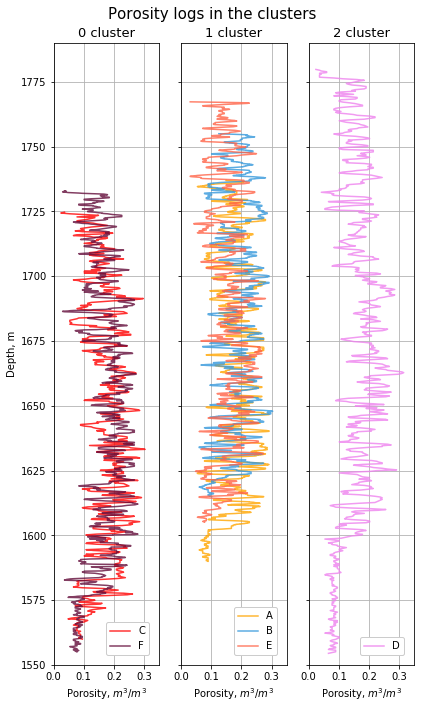

In [16]:
# если проницаемость кластеризуем то в 16 строке поменять на 'Permeability'
# логи выровнены по глубине
plt.figure(figsize = (6, 10))
plt.suptitle('Porosity logs in the clusters', fontsize = fontsize + 5)
nrows = 1
ncols = 3
index = 1 
yaxis = True
k = 2
for j in range(len(np.unique(clusters))):
    plt.subplot(nrows, ncols, index)
    plt.title(str(j) + ' cluster', fontsize = fontsize + 3)
    for i in header:   
        if i in well_names[j]:
            temp = df.loc[df.Well == i]
            temp = temp.filter(items = ['Porosity', 'Depth']).dropna()
            plot(x = temp.iloc[:, 0], y = temp.iloc[:, 1], xmin = xmin, xmax = xmax, 
                  xstep = xstep, ymin = ymin, ymax = ymax, ystep = ystep, xlabel = xlabel, 
                  ylabel = ylabel, color = customPalette[k], alpha = 0.8, label = i,
                  fontsize = 10, yaxis = yaxis)
            k += 1  
    index += 1
    legend = plt.legend(loc = 'lower right', ncol = 1, 
                        borderaxespad = 1, shadow = False, fontsize = fontsize, 
                        frameon = True, fancybox = True, framealpha = 1)#,  
    legend.get_frame();
    yaxis = False
plt.tight_layout()
plt.subplots_adjust(top = 0.93)

Далее немного стат анализа чтобы показатьчто пористость слабо меняется внутри кластеров

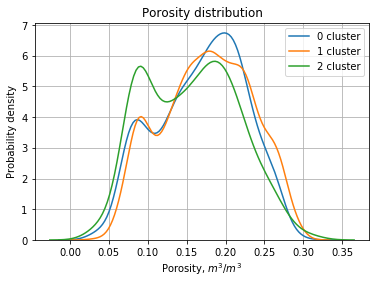

In [17]:
log = 'Porosity'
df_log = df.filter(items = [log, 'Well'])
df_log = df_log.loc[(df_log.Well == 'F') | (df_log.Well == 'C')]
df_log = df_log.filter(items = [log]).dropna()
ax = sns.distplot(df_log, hist = False, label = "0 cluster")

df_log = df.filter(items = [log, 'Well'])
df_log = df_log.loc[(df_log.Well == 'B') | (df_log.Well == 'A') | (df_log.Well == 'E')]
df_log = df_log.filter(items = [log]).dropna()
ax = sns.distplot(df_log, hist = False, label = "1 cluster")

df_log = df.filter(items = [log, 'Well'])
df_log = df_log.loc[df_log.Well == 'D']
df_log = df_log.filter(items = [log]).dropna()
ax = sns.distplot(df_log, hist = False, label = "2 cluster")
ax.set(xlabel = 'Porosity, ' + r'$m^3/m^3$', ylabel = 'Probability density')
plt.title('Porosity distribution')
plt.grid()

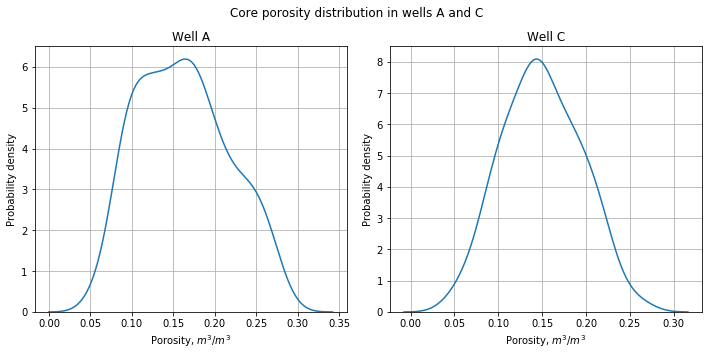

In [18]:
plt.figure(figsize = (10, 5))
plt.suptitle('Core porosity distribution in wells A and C')

plt.subplot(1, 2, 1)
path = 'Data/A.csv'
data = pd.read_csv(path, sep = ',', header = 0)
ax = sns.distplot(data.iloc[:,0:1], hist = False) # 1:2 для проницаемости
ax.set(xlabel = 'Porosity, ' + r'$m^3/m^3$', ylabel = 'Probability density')
plt.title('Well A')
plt.grid()

plt.subplot(1, 2, 2)
path = 'Data/C.csv'
data = pd.read_csv(path, sep = ',', header = 0)
ax = sns.distplot(data.iloc[:,0:1], hist = False) # 1:2 для проницаемости
ax.set(xlabel = 'Porosity, ' + r'$m^3/m^3$', ylabel = 'Probability density')
plt.title('Well C')
plt.grid()

plt.tight_layout()
plt.subplots_adjust(top = 0.87)
plt.show()

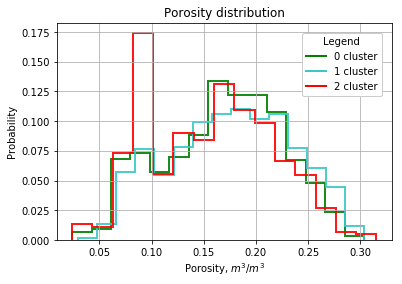

In [19]:
plt.figure(figsize = (6, 4))
fontsize = 10
bins = 15
a = df_box.loc[df_box.Cluster == 0].Porosity
a = a.dropna()
weights = np.ones_like(a)/float(len(a))
plt.hist(a, bins=bins, weights = weights, alpha = 0.9, lw = 2, histtype='step', fill=False, 
         label = '0 cluster', color = customPalette[0])

a= df_box.loc[df_box.Cluster == 1].Porosity
a= a.dropna()
weights = np.ones_like(a)/float(len(a))
plt.hist(a, bins=bins, weights = weights, alpha = 0.9, lw = 2, histtype='step', fill=False, 
         label = '1 cluster', color = customPalette[1])

a= df_box.loc[df_box.Cluster == 2].Porosity
a= a.dropna()
weights = np.ones_like(a)/float(len(a))
plt.hist(a, bins=bins, weights = weights, alpha = 0.9, lw = 2, histtype = 'step', fill = False, 
         label = '2 cluster', color = customPalette[2])
plt.xlabel('Porosity, ' + r'$m^3/m^3$')
plt.ylabel('Probability')
plt.title('Porosity distribution')

custom_lines = [Line2D([0], [0], color=customPalette[0], lw=2),
                Line2D([0], [0], color=customPalette[1], lw=2),
                Line2D([0], [0], color=customPalette[2], lw=2)]

legend = plt.legend(custom_lines, ['0 cluster', '1 cluster', '2 cluster'], loc = 'upper right', ncol = 1, 
                        borderaxespad = 1, shadow = False, fontsize = fontsize, 
                        frameon = True, fancybox = True, framealpha = 1, title = 'Legend')
legend.get_frame()
plt.grid()

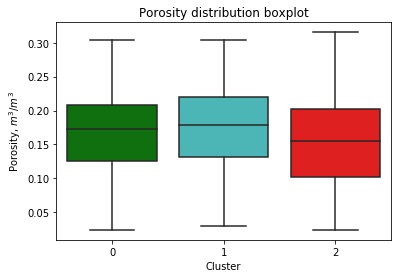

In [20]:
plt.figure(figsize = (6, 4))
my_pal = {"0": "g", "1": "b", "2":"m"}
labels = ['Cluster 1', 'Cluster 2', 'Cluster3']
g = sns.boxplot(x = 'Cluster', y = 'Porosity', data = df_box, palette = [customPalette[0], 
                                             customPalette[1], customPalette[2]])
g.set_xticklabels(g.get_xticklabels())
plt.title('Porosity distribution boxplot')
plt.grid(False)
plt.ylabel('Porosity, ' + r'$m^3/m^3$');

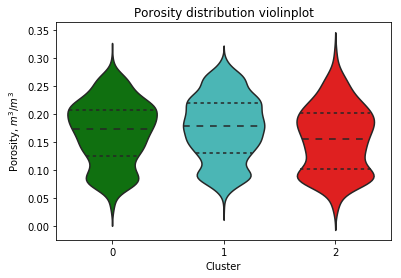

In [21]:
plt.figure(figsize = (6, 4))
my_pal = {"0": "g", "1": "b", "2":"m"}
labels = ['Cluster 1', 'Cluster 2', 'Cluster3']
g = sns.violinplot(x = 'Cluster', y = 'Porosity', data = df_box, palette = [customPalette[0], 
        customPalette[1], customPalette[2]],  inner="quartile")
g.set_xticklabels(g.get_xticklabels())
plt.title('Porosity distribution violinplot')
plt.grid(False)
plt.ylabel('Porosity, ' + r'$m^3/m^3$');